# Markov Chain Monte Carlo

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import theano
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### Good King Markov and His Island Kingdom

###### Code 8.1

In [14]:
num_weeks = 10000
positions = np.zeros(num_weeks)
current = 10

for i in range(num_weeks):
    # record current position
    positions[i] = current
    
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1,1])
    # make sure he loops around the archipelago
    proposal = np.where(proposal < 1, 10, proposal)
    proposal = np.where(proposal > 10, 1, proposal)

    # move?
    prob_move = proposal / current
    current = proposal if np.random.rand() < prob_move else current

###### Figure 8.1

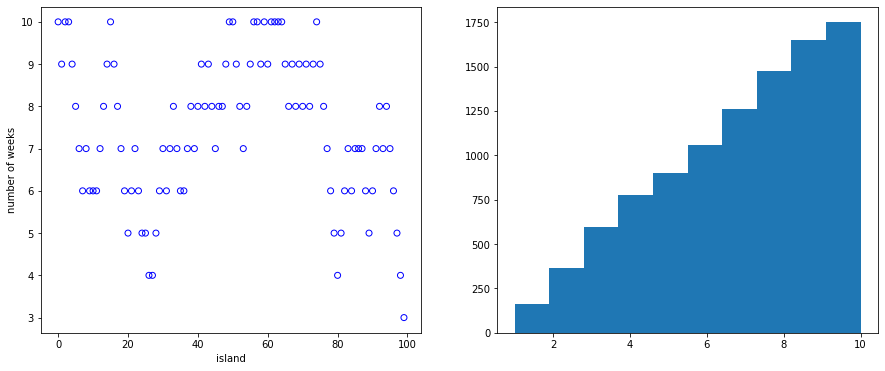

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(range(100), positions[:100], facecolors='none', edgecolors='b')
ax1.set_ylabel('island')
ax1.set_xlabel('week')

ax2.hist(positions, align='mid')
ax1.set_ylabel('number of weeks')
ax1.set_xlabel('island');

### Markov Chain Monte Carlo

### Easy HMC: `map2stan`

###### Code 8.2

In [38]:
d = pd.read_csv('../../data/rugged.csv', sep=';')
d['log_gdp'] = np.log(d.rgdppc_2000)
dd = d.loc[np.isfinite(d.rgdppc_2000),:]

###### Code 8.3

In [42]:
with pm.Model() as m8_1:
    a = pm.Normal('a', mu=0, sd=100)
    bR = pm.Normal('bR', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=10)
    bAR = pm.Normal('bAR', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
    sigma = pm.Uniform('sigma', 0, 10)
    log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
    trace_m8_1 = pm.sample(1000, tune=1000)
    
pm.summary(trace_m8_1, var_names=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1063.20draws/s]


,mean,sd,hpd_3%,hpd_97%
a,9.223,0.136,8.984,9.487
bR,-0.201,0.074,-0.333,-0.059
bA,-1.941,0.218,-2.340,-1.506
bAR,0.389,0.127,0.154,0.628
sigma,0.949,0.053,0.841,1.043


###### Code 8.4

In [43]:
dd_trim = dd.loc[:, ["log_gdp", "rugged", "cont_africa"]]
dd_trim.head()

,log_gdp,rugged,cont_africa
2,7.492609,0.858,1
4,8.216929,3.427,0
7,9.933263,0.769,0
8,9.407032,0.775,0
9,7.792343,2.688,0


###### Code 8.5

In [44]:
# WE USE PyMC3!!!
with pm.Model() as m8_1s:
    a = pm.Normal('a', mu=0, sd=100)
    bR = pm.Normal('bR', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=10)
    bAR = pm.Normal('bAR', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + bR * dd_trim.rugged + bA * dd_trim.cont_africa + bAR * dd_trim.rugged * dd_trim.cont_africa)
    sigma = pm.HalfCauchy('sigma', 2)
    log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd_trim.log_gdp)
    trace_m8_1s = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1054.03draws/s]


###### Code 8.6

In [45]:
pm.summary(trace_m8_1s, var_names=['~mu'], kind='stats')

,mean,sd,hpd_3%,hpd_97%
a,9.226,0.140,8.971,9.476
bR,-0.204,0.078,-0.348,-0.057
bA,-1.949,0.240,-2.392,-1.479
bAR,0.394,0.135,0.137,0.637
sigma,0.948,0.054,0.849,1.046


###### Code 8.7

In [47]:
# From what i understand, pm.sample() already runs in parallel
trace_m8_1s_4chains = pm.sample(1000, tune=1000, chains=4, cores=4, model=m8_1s)
pm.summary(trace_m8_1s_4chains, var_names=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:07<00:00, 1049.41draws/s]


,mean,sd,hpd_3%,hpd_97%
a,9.219,0.142,8.959,9.490
bR,-0.199,0.080,-0.351,-0.050
bA,-1.942,0.231,-2.346,-1.490
bAR,0.391,0.133,0.153,0.655
sigma,0.949,0.051,0.854,1.046


###### Code 8.8

In [52]:
trace_m8_1s_4chains.varnames

['a', 'bR', 'bA', 'bAR', 'sigma_log__', 'mu', 'sigma']

In [53]:
post = pm.trace_to_dataframe(trace_m8_1s, varnames=['a', 'bR', 'bA', 'bAR', 'sigma'])
post.head()

,a,bR,bA,bAR,sigma
0,9.100947,-0.135496,-2.025550,0.460102,0.949771
1,9.202215,-0.171319,-1.882669,0.361687,0.943081
2,9.309161,-0.280613,-2.035073,0.516042,0.917050
3,9.378004,-0.287481,-1.796919,0.236722,0.908832
4,9.138554,-0.210876,-2.104989,0.499854,0.971341


###### Code 8.9 & Code 8.10 & Figure 8.3

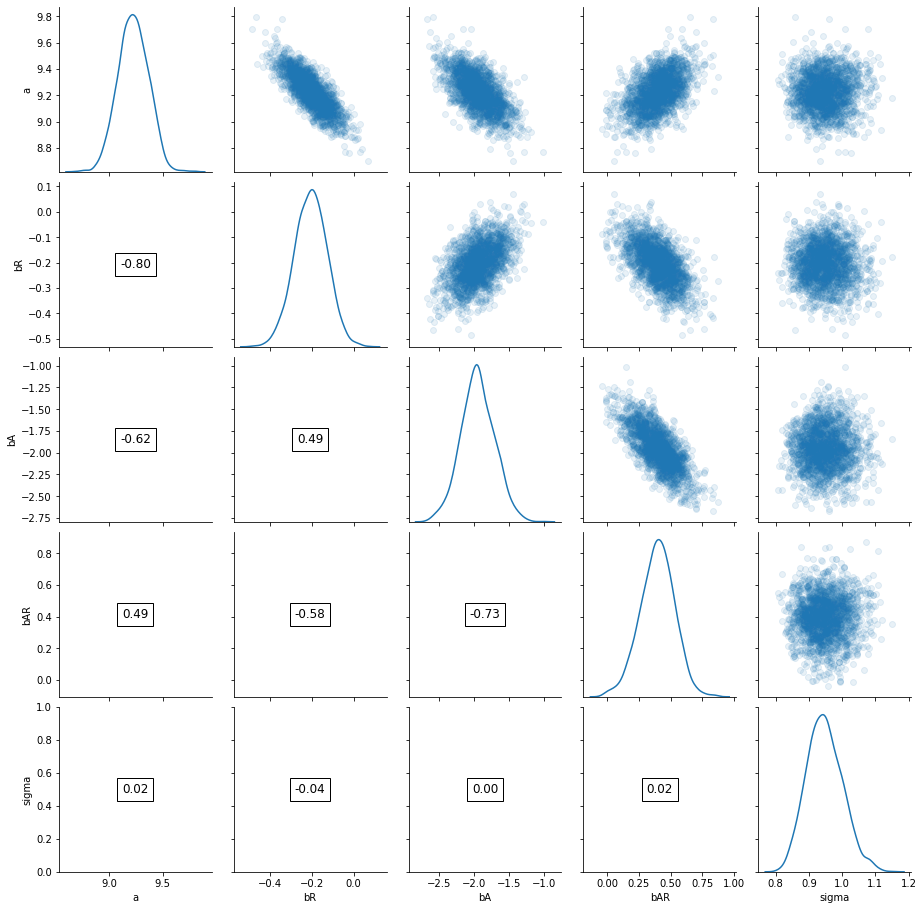

In [65]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10, prop={'fontsize': 12})
    plt.gca().add_artist(artist)
    plt.grid(b=False)

grid = (sns.PairGrid(post,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

###### Code 8.11

In [74]:
m8_1s

In [79]:
m8_1s.logp({varname: trace_m8_1s[varname].mean() for varname in trace_m8_1s.varnames})

array(-246.02248313)

In [73]:
pm.stats.effective_n(trace_m8_1s)

<xarray.Dataset>
Dimensions:   (mu_dim_0: 170)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 163 164 165 166 167 168 169
Data variables:
    a         float64 853.7
    bR        float64 790.8
    bA        float64 844.5
    bAR       float64 737.3
    mu        (mu_dim_0) float64 2.027e+03 988.7 ... 1.81e+03 2.233e+03
    sigma     float64 1.693e+03

In [84]:
pm.stats.waic(trace_m8_1s)

Computed from 2000 by 170 log-likelihood matrix

        Estimate       SE
IC_waic   469.53    14.88
p_waic      5.22        -

There has been a warning during the calculation. Please check the results.

###### Code 8.12 & Figure 8.4

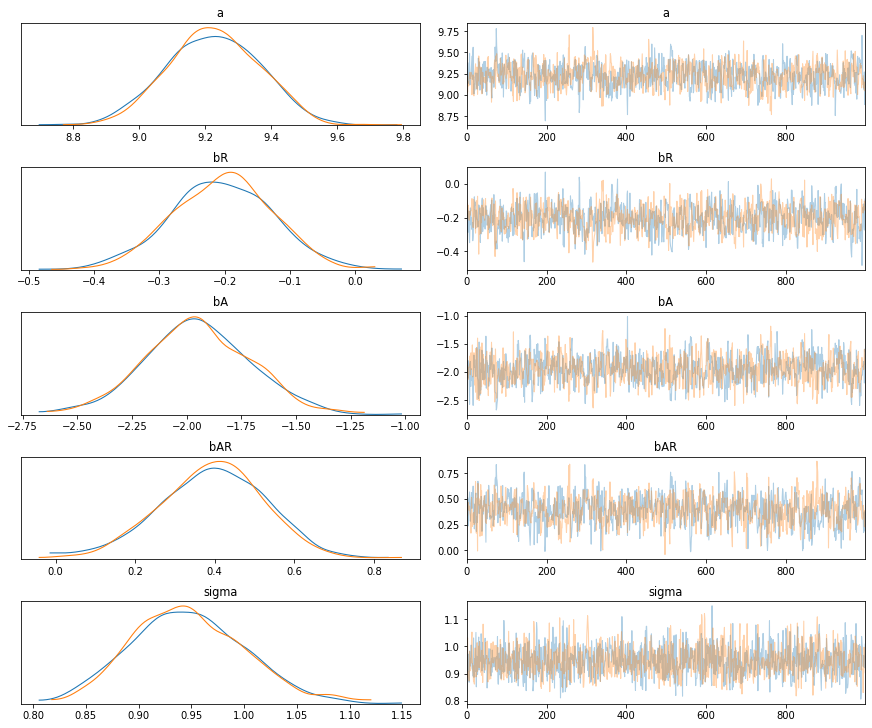

In [88]:
az.plot_trace(trace_m8_1s, var_names=['~mu']);

### Care and feeding of your Markov Chains

###### Code 8.13

In [89]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)
    trace_m8_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains, 147 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 447.04draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.674959010301901, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


###### Code 8.14

In [90]:
pm.summary(trace_m8_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,3.105794e+11,2.400352e+12,-4.120066e+12,5.709406e+12,4.394912e+11,3.138575e+11,30.0,30.0,26.0,45.0,1.10
sigma,4.768597e+12,2.107857e+13,1.278404e+09,1.818078e+13,1.266324e+12,8.963703e+11,277.0,277.0,21.0,48.0,1.09


###### Figure 8.5

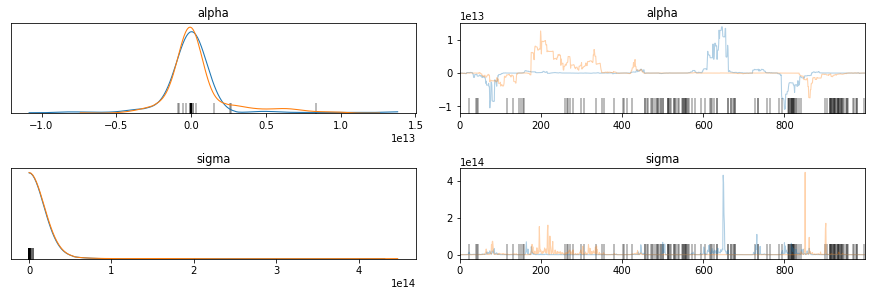

In [94]:
az.plot_trace(trace_m8_2);

In [96]:
pm.stats.effective_n(trace_m8_2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 25.81
    sigma    float64 20.9

###### Code 8.15

In [162]:
y = np.array([-1., 1.])

with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', mu=1, sd=10)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', mu=alpha, sd=sigma, observed=y)
    trace_m8_3 = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains, 4 divergences: 100%|██████████| 10000/10000 [00:04<00:00, 2029.86draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7001755063174414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796767499866767, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [163]:
pm.summary(trace_m8_3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.018,1.617,-2.983,3.081,0.039,0.027,1733.0,1733.0,2180.0,1687.0,1.0
sigma,1.983,1.877,0.468,4.558,0.048,0.034,1517.0,1517.0,1456.0,2112.0,1.0


###### Figure 8.6

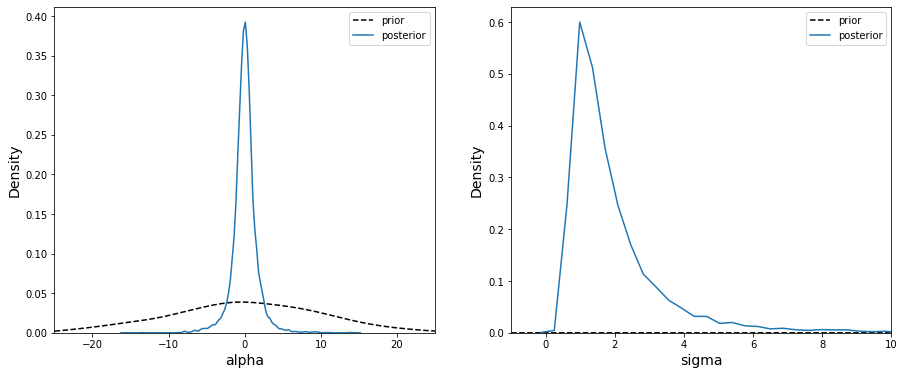

In [164]:
# For some reason the sigma priors dont come of similar to 
priors = pd.DataFrame(pm.sample_prior_predictive(model=m8_3, var_names=['alpha', 'sigma']))
posterior = pm.trace_to_dataframe(trace_m8_3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

for i, ax in enumerate([ax1, ax2]):
    sns.kdeplot(priors.iloc[:,i], ax=ax, label='prior', c='k', ls='--')
    sns.kdeplot(posterior.iloc[:,i], ax=ax, label='posterior')
    ax.set_xlabel(priors.columns[i], fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    
ax1.set_xlim((-25, 25))
ax2.set_xlim((-1, 10));

###### Code 8.16

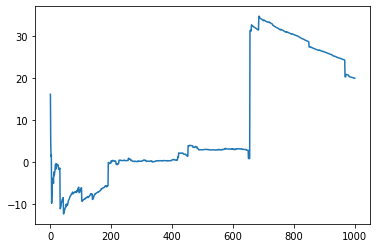

In [170]:
y = stats.cauchy.rvs(loc=0, scale=5, size=1000)
mu = np.cumsum(y) / (1 + np.arange(1000))
plt.plot(1 + np.arange(1000), mu);

###### Code 8.17

In [172]:
y = stats.norm.rvs(loc=0, scale=1, size=100)

###### Code 8.18

In [174]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    mu = pm.Deterministic('mu', a1 + a2)
    sigma = pm.HalfCauchy('sigma', 1)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    trace_m8_4 = pm.sample(4000, tune=1000)

pm.summary(trace_m8_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains, 429 divergences: 100%|██████████| 10000/10000 [07:07<00:00, 23.36draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6408513843996229, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 395 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19462179723331444, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,726.579,912.960,-1251.226,1441.414,572.221,462.936,3.0,3.0,3.0,21.0,2.67
a2,-726.537,912.959,-1441.435,1251.316,572.220,462.936,3.0,3.0,3.0,21.0,2.67
mu,0.043,0.096,-0.132,0.223,0.001,0.001,5699.0,3172.0,5714.0,3763.0,1.00
sigma,0.945,0.067,0.891,1.073,0.039,0.031,3.0,3.0,3.0,22.0,2.35


###### Code 8.19

In [175]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    mu = pm.Deterministic('mu', a1 + a2)
    sigma = pm.HalfCauchy('sigma', 1)
    y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    trace_m8_5 = pm.sample(4000, tune=1000)

pm.summary(trace_m8_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [01:41<00:00, 98.64draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a1,-0.029,6.982,-13.431,12.561,0.132,0.101,2791.0,2412.0,2788.0,3114.0,1.0
a2,0.074,6.981,-12.879,13.111,0.132,0.101,2791.0,2410.0,2789.0,3115.0,1.0
mu,0.044,0.096,-0.139,0.221,0.001,0.001,7455.0,5281.0,7461.0,6315.0,1.0
sigma,0.962,0.070,0.837,1.097,0.001,0.001,2809.0,2799.0,2821.0,2666.0,1.0


###### Figure 8.7

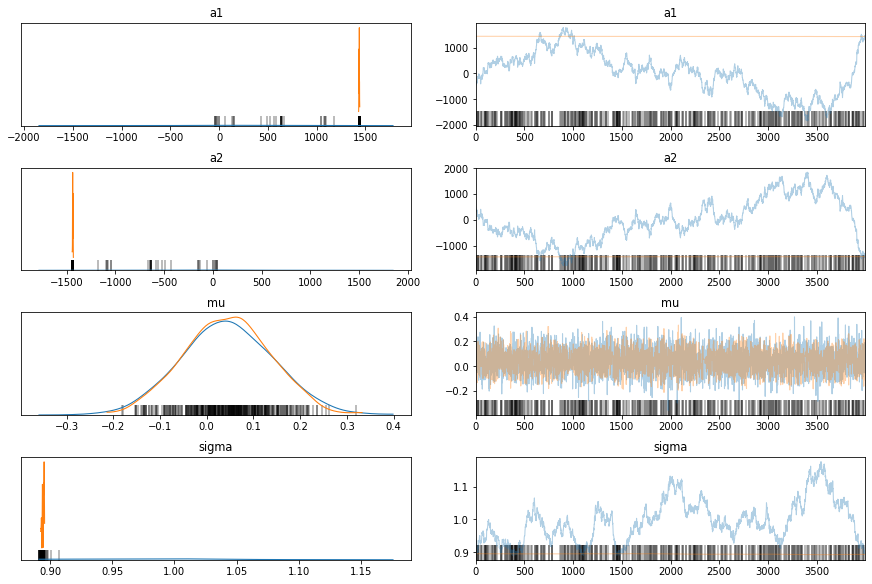

In [178]:
az.plot_trace(trace_m8_4);

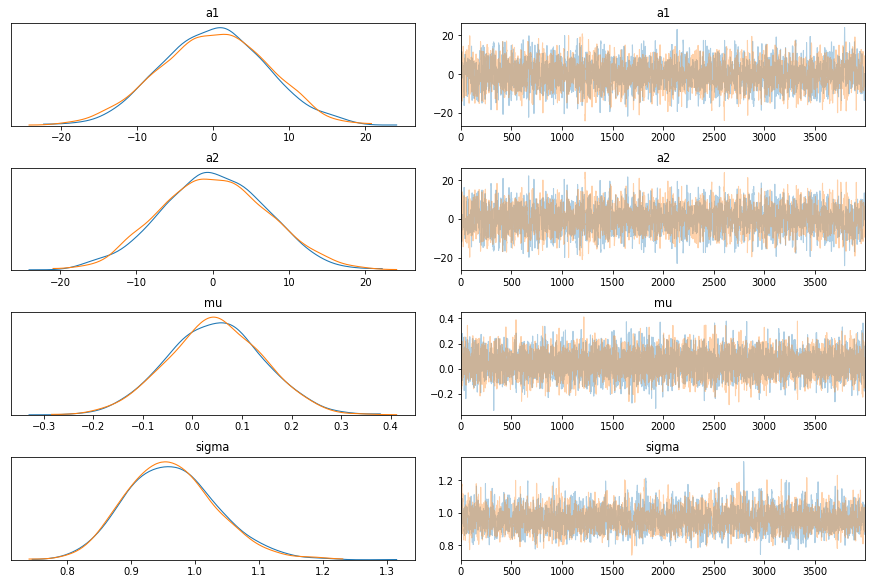

In [179]:
az.plot_trace(trace_m8_5);

In [14]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


